In [34]:
import torch
import geospaNN
import numpy as np
import time
import pandas as pd
import seaborn as sns
import scipy
import lhsmdu
import random

import matplotlib
import matplotlib.pyplot as plt

path = '/Users/zhanwentao/Documents/Abhi/Conference/IBC2024/data/'

In [2]:
def RMSE(x,y):
    x = x.reshape(-1)
    y = y.reshape(-1)
    n = x.shape[0]
    return(np.sqrt(np.sum(np.square(x-y))/n))

def f5(X): return (10 * np.sin(np.pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4]) / 6

sigma = 1
phi = 3
tau = 0.01
theta = torch.tensor([sigma, phi / np.sqrt(2), tau])

p = 5;
funXY = f5

n = 1000
nn = 20
batch_size = 50

N = 1000
n_small = int(N / 100)
np.random.seed(2021)
X_MISE = np.array(lhsmdu.sample(p, n_small).reshape((n_small, p)))
for i in range(99):
    temp = np.array(lhsmdu.sample(p, n_small).reshape((n_small, p)))
    X_MISE = np.concatenate((X_MISE, temp))

X_MISE_torch = torch.from_numpy(X_MISE).float()

In [3]:
torch.manual_seed(2025)
X, Y, coord, cov, corerr = geospaNN.Simulation(n, p, nn, funXY, theta, range=[0, 10])

X, Y, coord, _ = geospaNN.spatial_order(X, Y, coord, method='max-min')
data = geospaNN.make_graph(X, Y, coord, nn)

torch.manual_seed(2025)
np.random.seed(0)
data_train, data_val, data_test = geospaNN.split_data(X, Y, coord, neighbor_size=nn,
                                                      test_proportion=0.2)

In [4]:
import utils_pygam

In [28]:
torch.manual_seed(2024)
mlp_nn = torch.nn.Sequential(
    torch.nn.Linear(p, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 1)
)
nn_model = geospaNN.nn_train(mlp_nn, lr=0.01, min_delta=0.001)
training_log = nn_model.train(data_train, data_val, data_test)
theta0 = geospaNN.theta_update(mlp_nn(data_train.x).squeeze() - data_train.y,data_train.pos, neighbor_size=20)

Epoch 00076: reducing learning rate of group 0 to 5.0000e-03.
INFO: Early stopping
End at epoch79
---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covariates 1 (including intercept if specified).

Using the exponential spatial correlation model.

Using 15 nearest neighbors.



Source not compiled with OpenMP support.
----------------------------------------
	Building neighbor index
----------------------------------------
	Performing optimization
----------------------------------------
	Processing optimizers
----------------------------------------
Theta estimated as
[0.79345297 2.78086479 0.00924474]


In [29]:
Est_NN = mlp_nn(X_MISE_torch).detach().numpy()
RMSE(Est_NN, funXY(X_MISE))

0.16916494064829662

In [30]:
torch.manual_seed(2024)
mlp_nngls = torch.nn.Sequential(
    torch.nn.Linear(p, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1)
)
model_nngls = geospaNN.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_nngls, theta=torch.tensor(theta0))
nngls_model = geospaNN.nngls_train(model_nngls, lr=0.01, min_delta=0.001)
training_log = nngls_model.train(data_train, data_val, data_test,
                                 Update_init=20, Update_step=10)

---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covariates 1 (including intercept if specified).

Using the exponential spatial correlation model.

Using 15 nearest neighbors.



Source not compiled with OpenMP support.
----------------------------------------
	Building neighbor index
----------------------------------------
	Performing optimization
----------------------------------------
	Processing optimizers
----------------------------------------
Theta estimated as
[8.35265259e-01 2.74724996e+00 1.00000000e-03]
to
[8.35265259e-01 2.74724996e+00 1.00000000e-03]
---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covariates 1 (including intercept if specif

In [31]:
Est_NNGLS = mlp_nngls(X_MISE_torch).detach().numpy()
RMSE(Est_NNGLS, funXY(X_MISE))

0.13639756849393125

In [9]:
torch.manual_seed(2024)
np.random.seed(2024)
X_train = data_train.x.detach().numpy()
Y_train = data_train.y.detach().numpy()
gam = utils_pygam.my_LinearGAM()
gam.fit(X_train, Y_train)
Xspline = gam._modelmat(X_train)
gam.my_fit(X_train, Xspline, Y_train)

my_LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + intercept, tol=0.0001, 
   verbose=False)

In [32]:
Est_GAM = gam.predict(X_MISE)
RMSE(Est_GAM, funXY(X_MISE))

0.22922528849075086

In [11]:
torch.manual_seed(2024)
np.random.seed(2024)
X_train = data_train.x.detach().numpy()
Y_train = data_train.y.detach().numpy()
gam = utils_pygam.my_LinearGAM()
gam.fit(X_train, Y_train)
Xspline = gam._modelmat(X_train)
I_B_GAM, F_GAM = geospaNN.make_bf(data_train.pos, theta0, nn)
I_B_GAM = I_B_GAM.to_dense()
F_GAM = F_GAM.detach().numpy()
FI_B_GAM = (I_B_GAM.T * np.sqrt(np.reciprocal(F_GAM))).T
gam.my_fit(X_train,
           scipy.sparse.csr_matrix(np.matmul(FI_B_GAM, Xspline.todense())),
           np.array(np.matmul(FI_B_GAM, Y_train)))

my_LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + intercept, tol=0.0001, 
   verbose=False)

In [12]:
Est_GAMGLS = gam.predict(X_MISE)
RMSE(Est_GAMGLS, funXY(X_MISE))

[0.33128354609727484]

In [48]:
rho_vec = []
MSE_GAMGLS = []
MSE_NNGLS = []
for rho in list(np.array(range(21))/20):
    print(rho)
    def f5(X): return rho * (10 * np.sin(np.pi * X[:, 0] * X[:, 1]))/3 + \
                      (1-rho)*(20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:,4]) / 3

    funXY = f5
    torch.manual_seed(2024)
    X, Y, coord, cov, corerr = geospaNN.Simulation(n, p, nn, funXY, theta, range=[0, 10])
    random.seed(2024)
    X, Y, coord, _ = geospaNN.spatial_order(X, Y, coord, method='max-min')
    data = geospaNN.make_graph(X, Y, coord, nn)
    torch.manual_seed(2024)
    np.random.seed(0)
    data_train, data_val, data_test = geospaNN.split_data(X, Y, coord, neighbor_size=nn,
                                                          test_proportion=0.2)
    torch.manual_seed(2024)
    mlp_nngls = torch.nn.Sequential(
        torch.nn.Linear(p, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 20),
        torch.nn.ReLU(),
        torch.nn.Linear(20, 1)
    )
    model_nngls = geospaNN.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_nngls, theta=torch.tensor(theta0))
    nngls_model = geospaNN.nngls_train(model_nngls, lr=0.02, min_delta=0.001)
    training_log = nngls_model.train(data_train, data_val, data_test,
                                     Update_init=10, Update_step=5)
    Est_NNGLS = mlp_nngls(X_MISE_torch).detach().numpy()
    MSE_NNGLS.append(RMSE(Est_NNGLS, funXY(X_MISE)))
    
    torch.manual_seed(2024)
    np.random.seed(2024)
    X_train = data_train.x.detach().numpy()
    Y_train = data_train.y.detach().numpy()
    gam = utils_pygam.my_LinearGAM()
    gam.fit(X_train, Y_train)
    Xspline = gam._modelmat(X_train)
    I_B_GAM, F_GAM = geospaNN.make_bf(data_train.pos, theta0, nn)
    I_B_GAM = I_B_GAM.to_dense()
    F_GAM = F_GAM.detach().numpy()
    FI_B_GAM = (I_B_GAM.T * np.sqrt(np.reciprocal(F_GAM))).T
    gam.my_fit(X_train,
               scipy.sparse.csr_matrix(np.matmul(FI_B_GAM, Xspline.todense())),
               np.array(np.matmul(FI_B_GAM, Y_train)))
    
    Est_GAMGLS = gam.predict(X_MISE)
    MSE_GAMGLS.append(RMSE(Est_GAMGLS, funXY(X_MISE)))
    rho_vec.append(rho) 

0.0
---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covariates 1 (including intercept if specified).

Using the exponential spatial correlation model.

Using 15 nearest neighbors.



Source not compiled with OpenMP support.
----------------------------------------
	Building neighbor index
----------------------------------------
	Performing optimization
----------------------------------------
	Processing optimizers
----------------------------------------
Theta estimated as
[0.84889936 2.83509828 0.04546902]
to
[0.84889936 2.83509828 0.04546902]
---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covariates 1 (including intercept if specified).

Using the exp

In [49]:
df_MSE = pd.DataFrame(
    {'GAMGLS': np.array(MSE_GAMGLS), 'NNGLS': np.array(MSE_NNGLS), 'rho': np.array(rho_vec)})

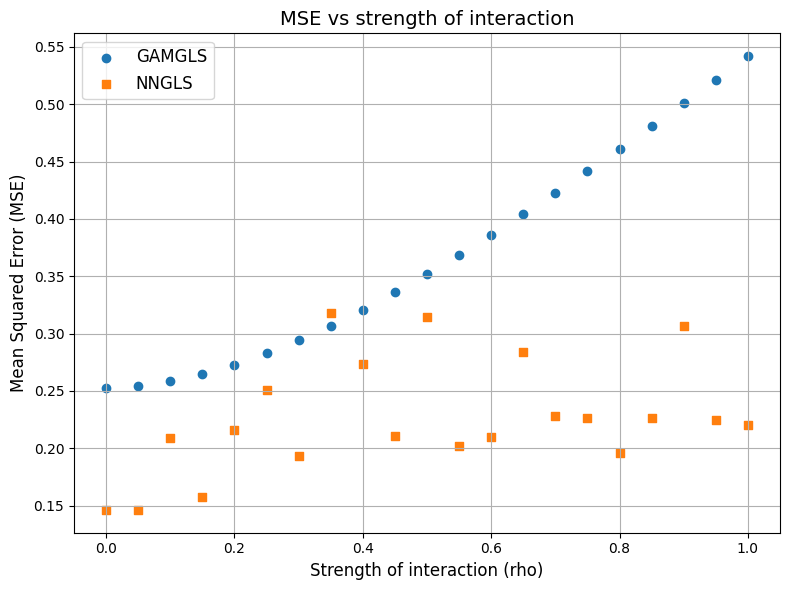

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot using Matplotlib
plt.figure(figsize=(8, 6))
plt.scatter(df_MSE['rho'], df_MSE['GAMGLS'], label='GAMGLS', marker='o')
plt.scatter(df_MSE['rho'], df_MSE['NNGLS'], label='NNGLS', marker='s')

# Add titles and labels
plt.title('MSE vs strength of interaction', fontsize=14)
plt.xlabel('Strength of interaction (rho)', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig(path + "GAM.png")

<Figure size 640x480 with 0 Axes>

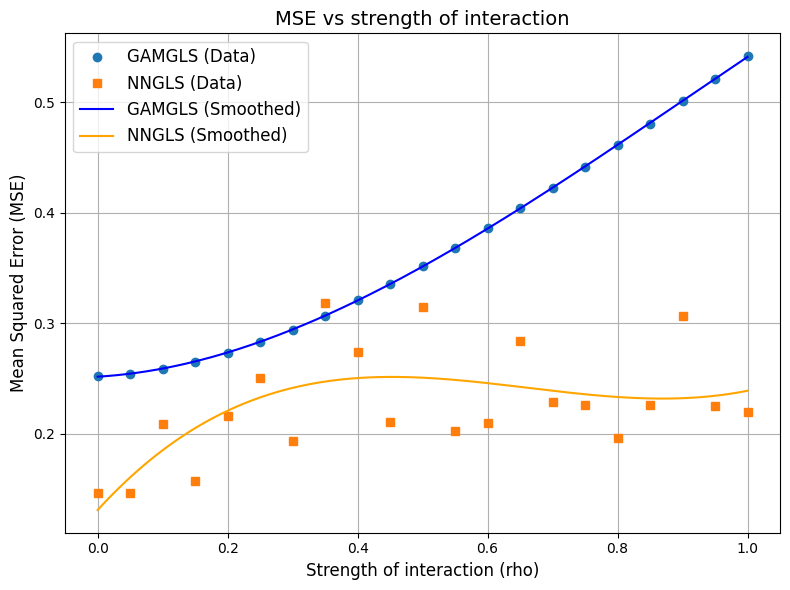

In [51]:
degree = 3  # Degree of the polynomial
rho_smooth = np.linspace(df_MSE['rho'].min(), df_MSE['rho'].max(), 200)

# Fit polynomials for GAMGLS and NNGLS
gamgls_fit = np.polyfit(df_MSE['rho'], df_MSE['GAMGLS'], degree)
nngls_fit = np.polyfit(df_MSE['rho'], df_MSE['NNGLS'], degree)

# Evaluate the polynomial on a smooth grid
gamgls_smooth = np.polyval(gamgls_fit, rho_smooth)
nngls_smooth = np.polyval(nngls_fit, rho_smooth)

# Plot using Matplotlib
plt.clf()
plt.figure(figsize=(8, 6))

# Original points
plt.plot(df_MSE['rho'], df_MSE['GAMGLS'], label='GAMGLS (Data)', marker='o', linestyle='none')
plt.plot(df_MSE['rho'], df_MSE['NNGLS'], label='NNGLS (Data)', marker='s', linestyle='none')

# Smoothed curves
plt.plot(rho_smooth, gamgls_smooth, label='GAMGLS (Smoothed)', color='blue', linestyle='-', linewidth=1.5)
plt.plot(rho_smooth, nngls_smooth, label='NNGLS (Smoothed)', color='orange', linestyle='-', linewidth=1.5)
# Add titles and labels
plt.title('MSE vs strength of interaction', fontsize=14)
plt.xlabel('Strength of interaction (rho)', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig(path + "GAM_fit.png")